# Import Modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences, plot_model

from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dropout, Dense, Embedding , SimpleRNN
from keras import Sequential


warnings.filterwarnings('ignore')

# Load The Dataset

In [5]:
train = pd.read_csv('/kaggle/input/fake-news/train.csv')

In [6]:
train.shape


(20800, 5)

In [4]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
train['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [6]:
train['text'][0]


'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Data Preprocesing

In [7]:
# drop unnecessary columns
train = train.drop(columns=['id', 'title', 'author'], axis=1)

In [8]:
# drop null values
train = train.dropna(axis=0)

In [9]:
train.shape


(20761, 2)

In [9]:
train.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
len(train)

20761

In [7]:
train.shape

(20761, 2)

In [13]:
train.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
# remove special characters and punctuations
train['clean_news'] = train['text'].str.lower()
train['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20761, dtype: object

In [11]:
train['clean_news'] = train['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
train['clean_news'] = train['clean_news'].str.replace('\n', '')
train['clean_news'] = train['clean_news'].str.replace('\s+', ' ')
train['clean_news']

0        house dem aide we didnt even see comeys letter...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29 2...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macys of today grew from the union of seve...
20798    nato russia to hold parallel exercises in balk...
20799     david swanson is an author activist journalis...
Name: clean_news, Length: 20761, dtype: object

In [13]:
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['clean_news'] = train['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
train.head()

,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


In [13]:
train.shape

(20761, 3)

In [26]:
list(np.sort(train['label'].unique()))

[0, 1]

In [27]:
train['label'].value_counts()

0    10387
1    10374
Name: label, dtype: int64

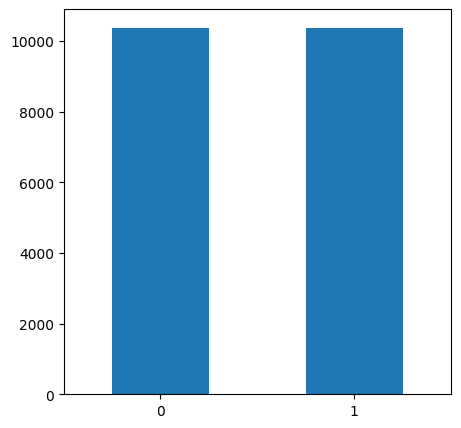

In [14]:
plt.figure(figsize=(5,5))
train['label'].value_counts().nlargest(10).plot(kind='bar')
plt.xticks(rotation=360)
plt.show()

In [20]:
train.keys()

Index(['text', 'label', 'clean_news'], dtype='object')

# Exploratory Data Analysis

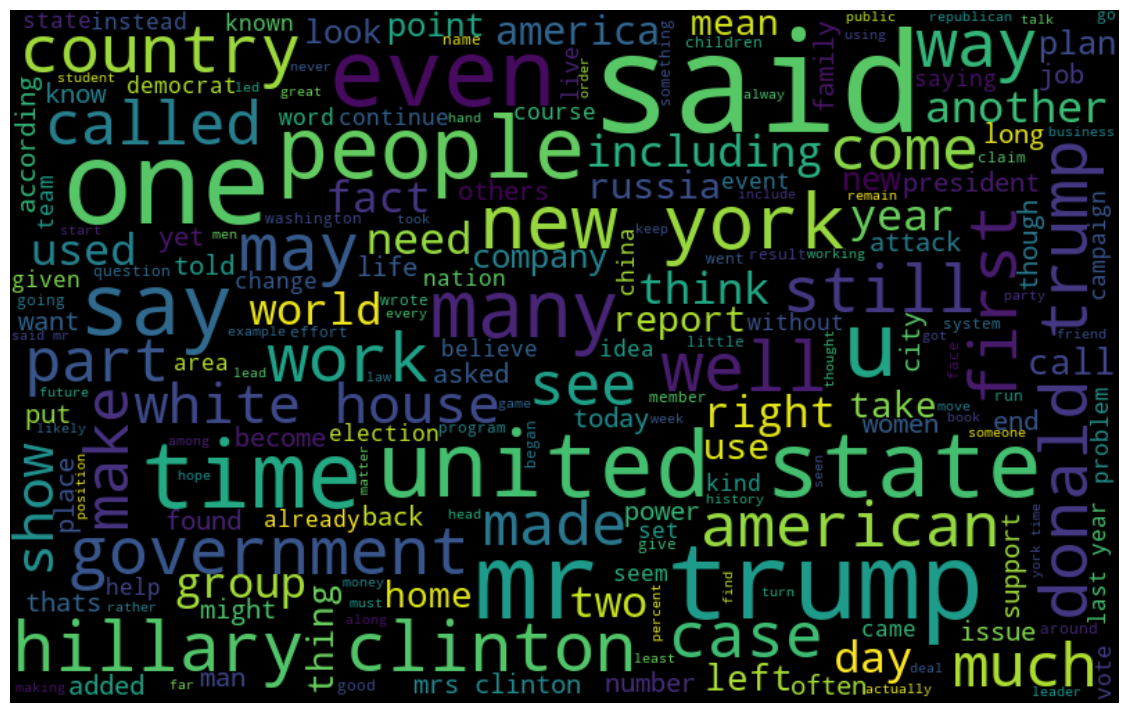

In [18]:
# # visualize the frequent words
# all_words = " ".join([sentence for sentence in train['clean_news']])

# wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# # plot the graph
# plt.figure(figsize=(15, 9))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

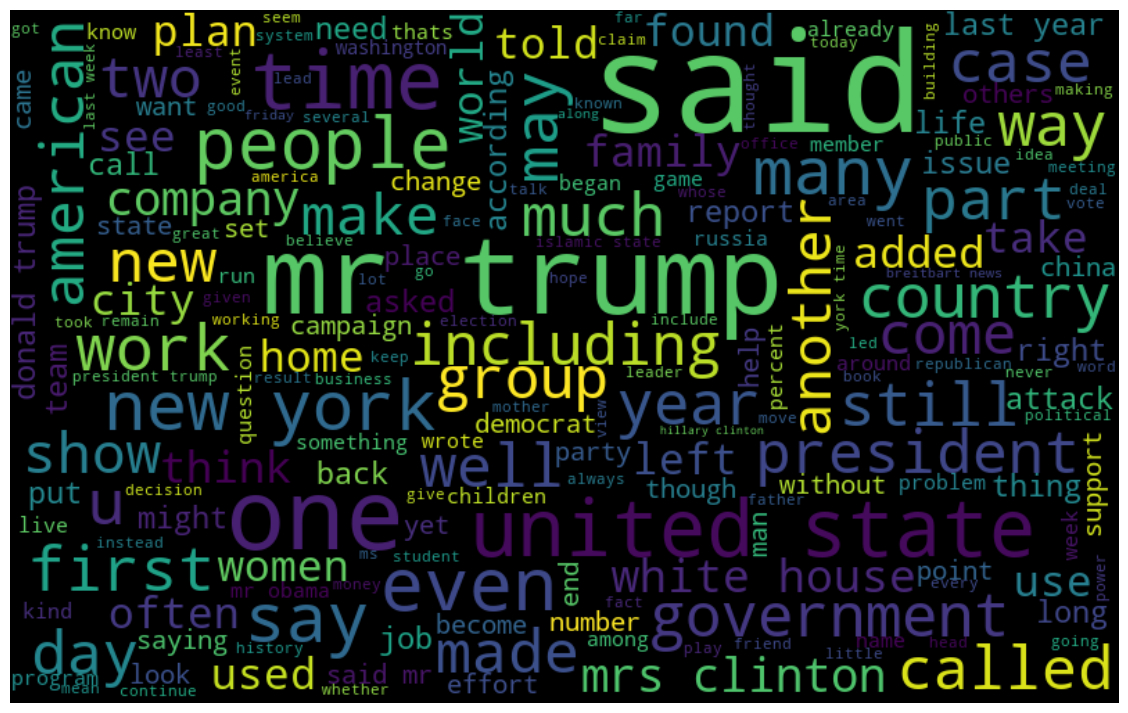

In [19]:
# # visualize the frequent words for Real news
# all_words = " ".join([sentence for sentence in train['clean_news'][train['label']==0]])

# wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# # plot the graph
# plt.figure(figsize=(15, 9))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

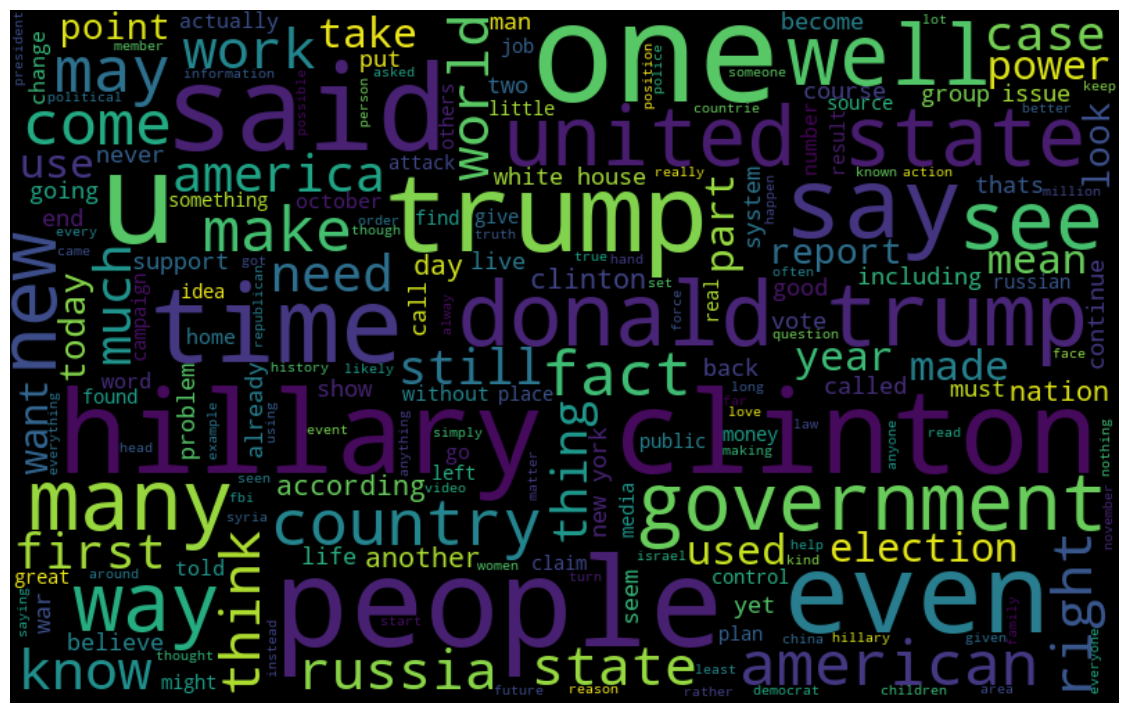

In [20]:
# # visualize the frequent words for fake news
# all_words = " ".join([sentence for sentence in train['clean_news'][train['label']==1]])

# wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# # plot the graph
# plt.figure(figsize=(15, 9))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Word Embeddings

In [24]:
# converting the textual data to numerical data

In [15]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size


199536

In [14]:
# word_index

In [16]:
# padding data
sequences = tokenizer.texts_to_sequences(train['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [16]:
padded_seq.shape

(20761, 500)

In [17]:
# create embedding index
embedding_index = {}
with open('/kaggle/input/glove6b/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [18]:
len(coefs)

100

In [19]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape


(199537, 100)

In [19]:
unknown_words = np.sum(np.sum(embedding_matrix, axis=1) == 0)
unknown_words #/ 100 #νοτ σουρ φορ δις αιμ ταιρεντ

97055

In [22]:
embedding_matrix[1]


array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

In [ ]:
padded_seq[1]

# Split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(padded_seq, train['label'], test_size=0.50, random_state=42)

In [32]:
x_train

array([[132588,     37,    244, ...,      0,      0,      0],
       [  6768,   1575,  17380, ...,      0,      0,      0],
       [    21,    571,    290, ...,      0,      0,      0],
       ...,
       [   482,    368,    256, ...,      0,      0,      0],
       [  6391,  31608,   1307, ..., 108334,   1945,   3353],
       [  6582,    618,    757, ...,   2194,     12,   1999]], dtype=int32)

In [33]:
y_train

6416     1
7646     0
1731     0
9291     0
1674     1
        ..
11307    0
11989    1
5401     1
862      0
15828    1
Name: label, Length: 10380, dtype: int64

In [34]:
x_test

array([[    3,   899,  2832, ...,   773,    39,   196],
       [  144, 18458,  1095, ...,     0,     0,     0],
       [ 2460,  2648, 19061, ...,     4,   242,    14],
       ...,
       [   79,   417,  2181, ...,  5398, 13707,   623],
       [  106,    63,   378, ...,  5044,   736,  1803],
       [  188,   202,    30, ...,     0,     0,     0]], dtype=int32)

In [35]:
y_test

14474    1
9606     1
14662    1
6451     0
16590    0
        ..
16215    0
20707    0
9358     0
2146     0
6104     1
Name: label, Length: 10381, dtype: int64

In [22]:
epochs = 100
batch_size=256
steps_per_epoch = x_train.shape[0]// batch_size

In [23]:
import tensorflow as tf

In [24]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=steps_per_epoch * 10,
  decay_rate=1,
  staircase=False)

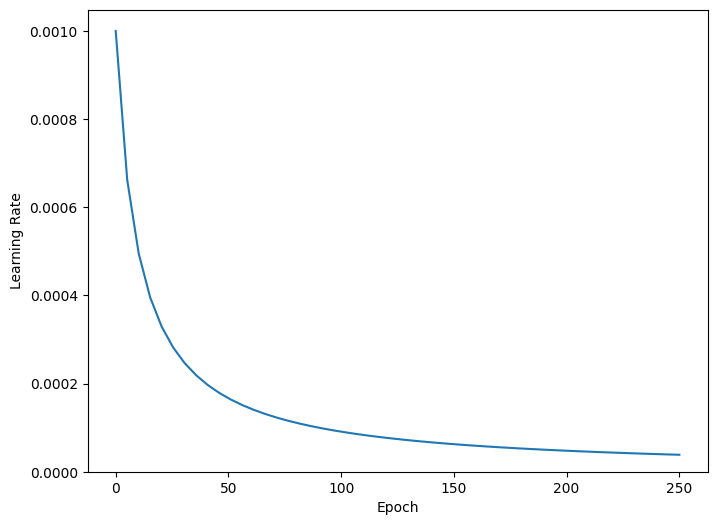

In [25]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/steps_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

# Model Training

In [40]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     LSTM(128),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])


In [41]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropour(0.2)
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(256)
#     Dense(1, activation='sigmoid')
# ])


In [42]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     LSTM(128,return_sequences=True),
#     Dropout(0.2),
#     LSTM(128),
#     Dropout(0.1),
#     Dense(512),
#     Dropout(0.2),
#     Dense(256),
#     Dropout(0.1),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])


In [59]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     Dropout(0.2),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     Dropout(0.1),
#     Dense(512),
#     Dropout(0.2),
#     Dense(256),
#     Dropout(0.1),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])


In [44]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     LSTM(128, return_sequences=True),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])


In [45]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

In [34]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     LSTM(128),
#     Dropout(0.2),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])
# #photo pc named lstm_128Units

In [49]:
# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     Dropout(0.2),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])
# # photo pc named rnn_128Units

In [ ]:
# from tensorflow.keras.layers import SimpleRNN

# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     SimpleRNN(128, activation='tanh', return_sequences=True),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])


In [35]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics='accuracy')


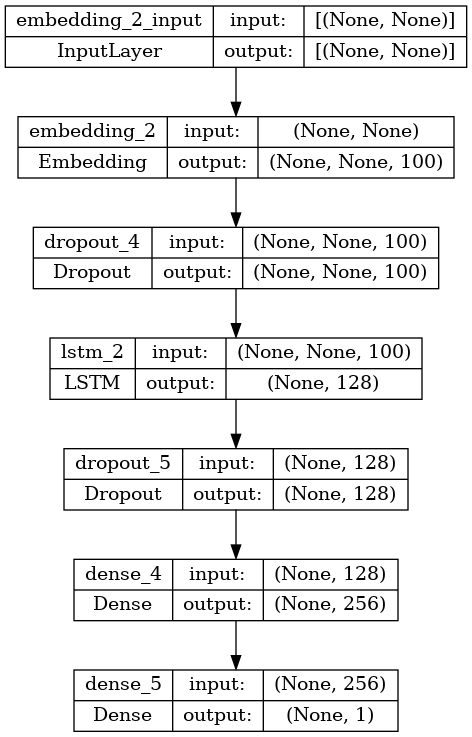

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         19953700  
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,104,229
Trainable params: 150,529
Non

In [61]:
# train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/100
41/41 [==============================] - 43s 955ms/step - loss: 0.6695 - accuracy: 0.6112 - val_loss: 0.6350 - val_accuracy: 0.6491
Epoch 2/100
41/41 [==============================] - 42s 1s/step - loss: 0.6214 - accuracy: 0.6642 - val_loss: 0.6560 - val_accuracy: 0.6260
Epoch 3/100
41/41 [==============================] - 38s 941ms/step - loss: 0.6766 - accuracy: 0.5830 - val_loss: 0.6452 - val_accuracy: 0.6351
Epoch 4/100
41/41 [==============================] - 40s 992ms/step - loss: 0.6346 - accuracy: 0.6615 - val_loss: 0.6053 - val_accuracy: 0.7100
Epoch 5/100
41/41 [==============================] - 40s 987ms/step - loss: 0.6014 - accuracy: 0.6977 - val_loss: 0.6760 - val_accuracy: 0.5491
Epoch 6/100
41/41 [==============================] - 40s 985ms/step - loss: 0.6817 - accuracy: 0.5576 - val_loss: 0.6655 - val_accuracy: 0.6263
Epoch 7/100
41/41 [==============================] - 39s 960ms/step - loss: 0.6647 - accuracy: 0.6134 - val_loss: 0.6542 - val_accuracy: 0.

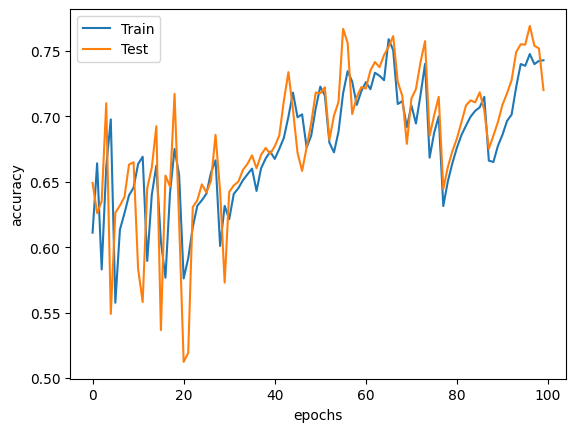

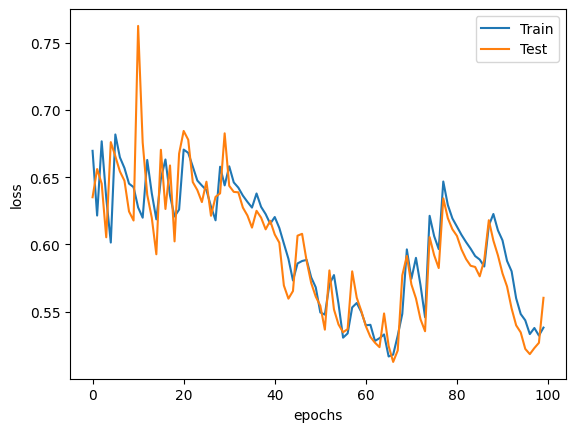

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend(['Train', 'Test'])
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend(['Train', 'Test'])
# plt.show()